 # MACHINE LEARNING FINAL PROJECT
 
 Rajwinder Singh,  Utkarsh Gupta, Henrique Rizzo
 
 The goal of the prjoect is to idenitfy cars and bicycles in a frame. 
 The results will be used to implement a real time system that guages the didtance of car and bikes to a helmet. 
 A camera will be mounted to a bicycle helmet.  THe bounding box/ width of identified pixels will determine the       proximity of the object (bike/car) near the camera. The heat map code is open source, from https://github.com/HTuennermann/Vehicle-Detection-and-Tracking/blob/master/LocalizationModel.ipynb

## Data

The data set comes from the KITTI vision benchmark data set (road) that has 15000 images of cars
http://www.cvlibs.net/download.php?file=data_object_image_2.zip

In [143]:
import keras

In [144]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Clear the Keras session.

In [145]:
import keras.backend as K
K.clear_session()

In [146]:
nrow = 64
ncol = 64

Now we follow the [VGG16 demo](./vgg16.ipynb) and load the deep VGG16 network.  Alternatively, you can use any other pre-trained model in keras.  When using the `applications.VGG16` method you will need to:
* Set `include_top=False` to not include the top layer
* Set the `image_shape` based on the above dimensions.  Remember, `image_shape` should be height x width x 3 since the images are color.

In [147]:
# TODO:  Load the VGG16 network
input_shape = (nrow, ncol, 3)
base_model = applications.VGG16(weights= 'imagenet', include_top = False, input_shape = input_shape) 

To create now new model, we create a Sequential model.  Then, loop over the layers in `base_model.layers` and add each layer to the new model.

In [148]:
# Create a new model
model = Sequential()

# TODO:  Loop over base_model.layers and add each layer to model
for i in range(len(base_model.layers)):
    model.add(base_model.layers[i])


Next, loop through the layers in `model`, and freeze each layer by setting `layer.trainable = False`.  This way, you will not have to *re-train* any of the existing layers.

In [149]:
# TODO
for i in range(len(base_model.layers)):
    layer = model.layers[i]
    layer.trainable = False


Now, add the following layers to `model`:
* A `Flatten()` layer which reshapes the outputs to a single channel.
* A fully-connected layer with 256 output units and `relu` activation
* A `Dropout(0.5)` layer
* A final fully-connected layer.  Since this is a binary classification, there should be one output and `sigmoid` activation.

In [150]:
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))


Print the model summary.  This will display the number of trainable parameters vs. the non-trainable parameters.

In [151]:
# TODO
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

## Using Generators to Load Data

Up to now, the training data has been represented in a large matrix.  This is not possible for image data when the datasets are very large.  For these applications, the `keras` package provides a `ImageDataGenerator` class that can fetch images on the fly from a directory of images.  Using multi-threading, training can be performed on one mini-batch while the image reader can read files for the next mini-batch. The code below creates an `ImageDataGenerator` for the training data.  In addition to the reading the files, the `ImageDataGenerator` creates random deformations of the image to expand the total dataset size.  This is a classic trick that was key in the early deep learning experiments.

In [152]:
# Car and bike data stored in my directory, /train and /test
train_data_dir = 'train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


Now, create a similar `test_generator` for the test data.

In [153]:
# TODO
# test_generator = ...
test_data_dir = 'test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 300 images belonging to 1 classes.


The following function displays images that will be useful below.

In [154]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

To see how the `train_generator` works, use the `train_generator.next()` method to get a minibatch of data `X,y`.  Display the first 8 images in this mini-batch and label the image with the class label.  You should see that bicycles have `y=0` and cars have `y=1`.

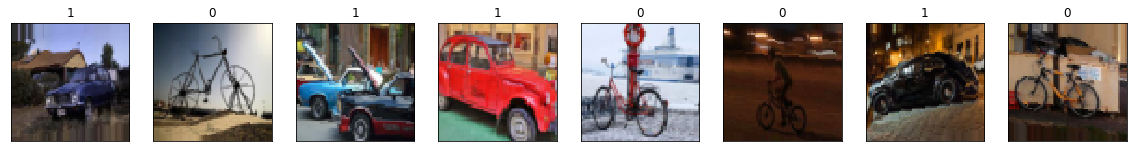

In [155]:
# TODO
x,y = train_generator.next()
nplot = 8
plt.figure(figsize = (20,20))
for i in range(nplot):
    plt.subplot(1, nplot, i+1)
    disp_image(x[i])
    plt.title(int(y[i]))

## Training the Model


In [160]:
# TODO.
model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizers.adam(lr=1e-3), 
              metrics = ['accuracy'])

In [157]:
# TODO
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

In [158]:
nepochs = 1  # Number of epochs

# Call the fit function
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/1
62/62 [==============================] - 184s 3s/step - loss: 0.4028 - acc: 0.8140 - val_loss: 3.6424 - val_acc: 0.0660


In [161]:
#  Saving the model to disk
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Transfer_Learning_model.h5")


## Code for Heat map generation

In [133]:
# This is from KITTI image data
# The images are stored in my directory /training and /testing
train_data_dir = 'training'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')



Found 7481 images belonging to 1 classes.


In [134]:
test_data_dir = 'testing'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 7518 images belonging to 1 classes.


In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

## Generating a new model

This new model will be generated to compare to the transfer learning model generated above.  
This code is from https://github.com/HTuennermann/Vehicle-Detection-and-Tracking/blob/master/LocalizationModel.ipynb

In [114]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename = None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(10, (3, 3), activation='relu', name='conv1', input_shape=input_shape, padding="same"))
    model.add(Conv2D(10, (3, 3), activation='relu', name='conv2', padding="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,(8,8), activation="relu", name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Conv2D(1, (1,1), name="dense2", activation="tanh")) # This was Dense(1)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

In [115]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 10)        280       
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 10)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 10)          0         
_________________________________________________________________
dense1 (Conv2D)              (None, 1, 1, 128)         82048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 128)         0         
__________

In [37]:
# fit this heat map model
from keras_tqdm import TQDMNotebookCallback

nepochs = 15
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks = [TQDMNotebookCallback()] )

# score = model.evaluate(X_test, Y_test, verbose=0)


Epoch 1/15
233/233 [==============================] - 1167s 5s/step - loss: 1.0807e-04 - acc: 1.0000 - val_loss: 9.5253e-11 - val_acc: 1.0000


Epoch 2/15
233/233 [==============================] - 975s 4s/step - loss: 1.4725e-06 - acc: 1.0000 - val_loss: 1.9783e-11 - val_acc: 1.0000


Epoch 3/15
233/233 [==============================] - 950s 4s/step - loss: 5.5021e-07 - acc: 1.0000 - val_loss: 1.4465e-09 - val_acc: 1.0000


Epoch 4/15
233/233 [==============================] - 959s 4s/step - loss: 3.3802e-07 - acc: 1.0000 - val_loss: 2.0106e-10 - val_acc: 1.0000


Epoch 5/15
233/233 [==============================] - 970s 4s/step - loss: 2.2156e-07 - acc: 1.0000 - val_loss: 1.2759e-08 - val_acc: 1.0000


Epoch 6/15
233/233 [==============================] - 961s 4s/step - loss: 1.7215e-07 - acc: 1.0000 - val_loss: 4.1222e-08 - val_acc: 1.0000


Epoch 7/15
233/233 [==============================] - 964s 4s/step - loss: 1.2777e-07 - acc: 1.0000 - val_loss: 4.4589e-08 - val_acc: 1.0000


Epoch 8/15
233/233 [==============================] - 972s 4s/step - loss: 1.0493e-07 - acc: 1.0000 - val_loss: 2.1300e-09 - val_acc: 1.0000


Epoch 9/15
233/233 [==============================] - 1087s 5s/step - loss: 8.4513e-08 - acc: 1.0000 - val_loss: 3.6709e-08 - val_acc: 1.0000


Epoch 10/15
233/233 [==============================] - 961s 4s/step - loss: 7.6426e-08 - acc: 1.0000 - val_loss: 5.1927e-09 - val_acc: 1.0000


Epoch 11/15
233/233 [==============================] - 953s 4s/step - loss: 6.4983e-08 - acc: 1.0000 - val_loss: 9.5122e-10 - val_acc: 1.0000


Epoch 12/15
233/233 [==============================] - 966s 4s/step - loss: 6.2518e-08 - acc: 1.0000 - val_loss: 8.5912e-11 - val_acc: 1.0000


Epoch 13/15
233/233 [==============================] - 972s 4s/step - loss: 5.0299e-08 - acc: 1.0000 - val_loss: 6.1976e-09 - val_acc: 1.0000


Epoch 14/15
233/233 [==============================] - 962s 4s/step - loss: 4.4633e-08 - acc: 1.0000 - val_loss: 1.9866e-08 - val_acc: 1.0000


Epoch 15/15
233/233 [==============================] - 1036s 4s/step - loss: 3.9924e-08 - acc: 1.0000 - val_loss: 4.0247e-10 - val_acc: 1.0000


## Saving the weights

The above neural netowrk  is computationally expensive on a CPU.
Saving the weights to resuse for other sessions 

In [38]:
model.save_weights("localize.h5")

In [169]:
heatmodel = get_conv(input_shape=(None,None,3), filename="localize.h5")

## Testing the heatmap generator

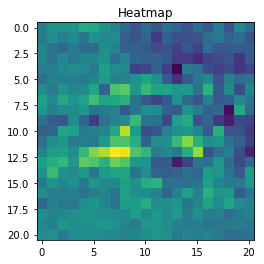

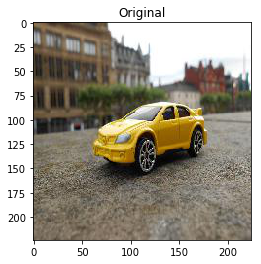

In [182]:
def locate(data):
    
    
    heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

annotated = locate(t)

plt.title("Original")    
plt.imshow(annotated)
plt.show()


As shown above, the heat map didn't work for the input images.